In [1]:
import jax.numpy as np
from jax import random
from jax import jit, grad, jvp
import numpy as onp
import matplotlib.pyplot as plt
import scipy.linalg
from jax.flatten_util import ravel_pytree
import scipy.sparse.linalg as la
np.set_printoptions(precision=4, suppress=True)
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
def f1(V,W):
  return np.sum(W*(S - V@V.T)) 

def f2(V,W):
  return -f1(V,W) + 0.5*lam*np.trace(W.T@W)

onp.random.seed(0)
d = 3
U = onp.random.randn(d,d)
S = scipy.linalg.sqrtm(U @ U.T)

V = onp.random.randn(d,d)
W = onp.random.randn(d,d)

lam = 0.1

D1f1 = grad(f1, argnums=0)
D2f1 = grad(f1, argnums=1)
D2f2 = grad(f2, argnums=1)
D1f2 = grad(f2, argnums=0)

D22f2 = lambda V,W: lambda v: jvp(lambda W: D2f2(V,W), (W,), (v, ))[1]
D12f2 = lambda V,W: lambda v: jvp(lambda V: D2f2(V,W), (V,), (v, ))[1]

0.18s, 0.02ms per iteration
compile: 0.10s


/Users/tfiez/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


9.82s, 0.98ms per iteration


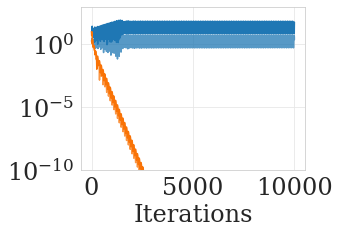

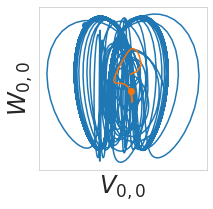

In [3]:
import time 
import seaborn as sns
from seaborn import xkcd_rgb as xkcd


def build_closures(S,lam=0.1):
  def f1(V,W):
    return np.sum(W*(S - V@V.T)) 

  def f2(V,W):
    return -f1(V,W) + 2*lam*np.trace(W.T@W)

  D1f1 = grad(f1, argnums=0)
  D2f1 = grad(f1, argnums=1)
  D2f2 = grad(f2, argnums=1)
  D1f2 = grad(f2, argnums=0)

  D22f2 = lambda V,W: lambda v: jvp(lambda W: D2f2(V,W), (W,), (v, ))[1]
  D12f2 = lambda V,W: lambda v: jvp(lambda V: D2f2(V,W), (V,), (v, ))[1]
  
  return D12f2
 
def dynamics(seed=1, num_iter=10000, d=2, η1=lambda _: 0.001, η2=lambda _: 0.001, stack=0, lam=0.1):
  lam = lam*d
  W_ = onp.zeros((num_iter, d, d))
  V_ = onp.zeros((num_iter, d, d))

  onp.random.seed(seed)
  U = onp.random.randn(d,d)
  S = U@U.T
  
  D12f2_ = build_closures(S, lam=lam)
  @jit
  def D12f2(V,W,v):
    return D12f2_(V,W)(v)
  
  V_[0] = onp.random.randn(d,d)
  W_[0] = onp.random.randn(d,d)
  
  V_[1] = V_[0]
  W_[1] = W_[0]

  if stack != 0:
    start_time = time.time()
    D12f2(V_[0], W_[0], V_[0])
    end_time = time.time() - start_time
    print('compile: {:.2f}s'.format(end_time))
  
  start_time = time.time()
  for k in range(1, num_iter-1):
    STACK = stack*D12f2(V_[k], W_[k], (S-V_[k]@V_[k].T)/lam) if stack != 0 else 0
    V_[k+1] = V_[k] - η1(k) * (-(W_[k] + W_[k].T)@V_[k] - STACK)
    W_[k+1] = W_[k] - η2(k) * (V_[k]@V_[k].T - S + lam*W_[k])

  duration = time.time() - start_time
  print('{:.2f}s, {:.2f}ms per iteration'.format(duration, duration/num_iter*1000))
  return V_, W_, U

def schedule(η1,η2,num_iter,**kwargs):
  k = np.linspace(0,num_iter-1,num_iter)
  return η1(k), η2(k)

def T(A):
  return onp.transpose(A, axes=[0,2,1])

def norms(V_,W_,U):
  return np.linalg.norm((W_ + T(W_))/2, axis=(1,2), ord='fro'), \
         np.linalg.norm(V_ @ T(V_) - U@U.T, axis=(1,2), ord='fro'), 
  


save = []
def run_and_plot(lr, d, lam, num_iter=1000, savefig=None, title=None, legend=True):
  # lr = 0.001
  γ1 = 1-1e-5
  γ2 = 1-1e-7

  kwargs = dict(
    num_iter = num_iter,
    d = d,
    η1 = lambda k: lr*γ1**k,
    η2 = lambda k: lr*γ2**k,
    lam = lam
  )

  V_simgrad, W_simgrad, U = dynamics(seed=0, stack=0, **kwargs)
  Vnorm_simgrad, Wnorm_simgrad = norms(V_simgrad, W_simgrad, U)
  plt.show()

  V_stack, W_stack, U  = dynamics(seed=0, stack=1, **kwargs)
  Vnorm_stack, Wnorm_stack = norms(V_stack, W_stack, U)
  plt.show()
  
  string = 'd: {:d}, lr: {:.4f}, reg: {:.4f}'.format(d,lr,lam) if title is None else title
  plot((Vnorm_simgrad, Wnorm_simgrad), (Vnorm_stack, Wnorm_stack), savefig, string, legend=legend)
  return (lr,d), (V_simgrad, W_simgrad), (V_stack, W_stack)

def plot(simgrad, stack, savefig=None, string='', legend=True):
  Vnorm_simgrad, Wnorm_simgrad = simgrad
  Vnorm_stack, Wnorm_stack = stack
  
  fs2 = 24

  colors = dict(simgrad='#1f77b4', stack=xkcd['orange'])

  sns.set_style('whitegrid', {'font.family':['serif'], 'font.serif':['Times New Roman'], 
                'grid.color':'.9'})

  fig, ax = plt.subplots(figsize=(4,3))
  ax.plot(Wnorm_simgrad, color=colors['simgrad'], label=r'simgrad: $\|\|\frac{1}{2}(W+W^\top)\|\|_2$')
  ax.plot(Vnorm_simgrad, alpha=0.75, color=colors['simgrad'], label=r'simgrad: $\|\|\Sigma - V\ V^\top\|\|_2$')
  ax.plot(Wnorm_stack, color=colors['stack'], label=r'stack: $\|\|\frac{1}{2}(W+W^\top)\|\|_2$')
  ax.plot(Vnorm_stack, alpha=0.75, color=colors['stack'], label=r'stack: $\|\|\Sigma - V\ V^\top\|\|_2$')
  ax.set_yscale('log')
  ax.set_ylim([1e-10,1e3])
  ax.set_title(string)
  ax.tick_params(labelsize=fs2)
  ax.set_xlabel('Iterations', fontsize=fs2)
  if legend: plt.legend(fontsize=fs2-2, bbox_to_anchor=(1,1))
  if savefig != None: plt.savefig(savefig, bbox_inches='tight')
  plt.show()
  

def plot_limit(SG, ST, savefig):
  colors = dict(simgrad='#1f77b4', stack=xkcd['orange'])
  fig, ax = plt.subplots(figsize=(3,3))
  
  fs2 = 24
  
  sns.set_style('whitegrid', {'font.family':['serif'], 'font.serif':['Times New Roman'], 
                'grid.color':'.9'})
  ax.plot(SG[0][:,0,0], SG[1][:,0,0], color=colors['simgrad'])
  ax.plot(SG[0][-1,0,0], SG[1][-1,0,0], 'o', color=colors['simgrad'])
  
  ax.plot(ST[0][:,0,0], ST[1][:,0,0], color=colors['stack'])
  ax.plot(ST[0][-1,0,0], ST[1][-1,0,0], 'o', color=colors['stack'])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('$V_{0,0}$', fontsize=fs2)
  ax.set_ylabel('$W_{0,0}$', fontsize=fs2)
  plt.savefig(savefig, bbox_inches='tight')
  
savedir = ''
_, SG_3, ST_3 = run_and_plot(d=3, lr=0.015, lam=.2, num_iter=10000, title='', savefig='cest_d3.pdf', legend=False)
plot_limit(SG_3, ST_3, savefig='cest_d3_traj.pdf')
# run_and_plot(d=5, lr=0.009, lam=.2, num_iter=10000, title='', savefig='cest_d5.pdf')

In [ ]:
_, SG_10, ST_10 = run_and_plot(d=9, lr=0.015, lam=.2, num_iter=10000, title='', savefig='cest_d10.pdf', legend=False)
plot_limit(SG_10, ST_10, savefig='cest_d10_traj.pdf')

0.25s, 0.03ms per iteration
compile: 0.17s


In [ ]:
_, SG_25, ST_25 = run_and_plot(d=25, lr=0.015, lam=.2, num_iter=10000, title='', savefig='cest_d25.pdf', legend=True)
plot_limit(SG_25, ST_25, savefig='cest_d25_traj.pdf')

In [ ]:
_,SG50, ST50 = run_and_plot(d=50, lr=0.015, lam=.2, num_iter=10000, title='', savefig='cest_d50.pdf', legend=True)
plot_limit(SG50, ST50, savefig='cest_d50_traj.pdf')